In [1]:
from nba_api.stats.endpoints import LeagueGameLog
import pandas as pd
import numpy as np
import os 
import glob
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Reimport and Clean data
data fetched from NBA API using methods in get_data.ipynb

In [2]:
season = '2023-24'
game_log = LeagueGameLog(season=season, season_type_all_star='Regular Season').get_data_frames()[0]

In [3]:
files = glob.glob(os.path.join('Data/',"*.csv"))
dataframes = {}

for file in files:
    file_name = os.path.basename(file)
    base_name = os.path.splitext(file_name)[0]

    df = pd.read_csv(file)

    dataframes[base_name] = df

advanced_box23 = dataframes['2023-24_advanced_box_data']
play_by_play23 = dataframes['2023-24_play_by_play']
play_tracking23 = dataframes['2023-24_playertracking_data']
shot_chart23 = dataframes['2023-24_shotchart_data']

play_type23 = dataframes['2023-24_play_type']


# Merge in stages
box = advanced_box23.merge(play_tracking23, on='personId', how='outer')
#merged_df2 = merged_df1.merge(play_tracking23, on='personId', how='outer')
#game_stats_2324 = merged_df2.merge(shot_chart23, on='personId', how='outer')




In [4]:
# Create key columns
advanced_box23['combined_key'] = advanced_box23['gameId'].astype(str) + '_' + advanced_box23['personId'].astype(str)
play_tracking23['combined_key'] = play_tracking23['gameId'].astype(str) + '_' + play_tracking23['personId'].astype(str)

#merge on key drop duplcated columns 
#https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
box23_24 = advanced_box23.merge(play_tracking23, on='combined_key', how='outer', suffixes=('', '_y'))
box23_24.drop(box23_24.filter(regex='_y$').columns, axis=1, inplace=True)
box23_24.drop(columns=['combined_key'])


gameId      teamId     teamCity   teamName teamTricode   teamSlug  \
0      22300001  1610612754      Indiana     Pacers         IND     pacers   
1      22300001  1610612754      Indiana     Pacers         IND     pacers   
2      22300001  1610612739    Cleveland  Cavaliers         CLE  cavaliers   
3      22300001  1610612739    Cleveland  Cavaliers         CLE  cavaliers   
4      22300001  1610612739    Cleveland  Cavaliers         CLE  cavaliers   
...         ...         ...          ...        ...         ...        ...   
32380  22301230  1610612740  New Orleans   Pelicans         NOP   pelicans   
32381  22301230  1610612747  Los Angeles     Lakers         LAL     lakers   
32382  22301230  1610612740  New Orleans   Pelicans         NOP   pelicans   
32383  22301230  1610612740  New Orleans   Pelicans         NOP   pelicans   
32384  22301230  1610612747  Los Angeles     Lakers         LAL     lakers   

       personId firstName   familyName           nameI  ...  \
0       1626167     Myles       Turner       M. Turner  ...   
1       1627741     Buddy        Hield        B. Hield  ...   
2       1627745    Damian        Jones        D. Jones  ...   
3       1627747     Caris       LeVert       C. LeVert  ...   
4       1627777   Georges        Niang        G. Niang  ...   
...         ...       ...          ...             ...  ...   
32380    202685     Jonas  Valanciunas  J. Valanciunas  ...   
32381    203076   Anthony        Davis        A. Davis  ...   
32382    203468        CJ     McCollum     C. McCollum  ...   
32383    203469      Cody       Zeller       C. Zeller  ...   
32384      2544    LeBron        James        L. James  ...   

      contestedFieldGoalsMade contestedFieldGoalsAttempted  \
0                           2                            5   
1                           1                            2   
2                           0                            0   
3                           4                            7   
4                           1                            2   
...                       ...                          ...   
32380                       0                            0   
32381                       0                            0   
32382                       0                            0   
32383                       0                            0   
32384                       0                            0   

      contestedFieldGoalPercentage  uncontestedFieldGoalsMade  \
0                            0.400                          7   
1                            0.500                          4   
2                            0.000                          0   
3                            0.571                          1   
4                            0.500                          3   
...                            ...                        ...   
32380                        0.000                          0   
32381                        0.000                          0   
32382                        0.000                          0   
32383                        0.000                          0   
32384                        0.000                          0   

      uncontestedFieldGoalsAttempted  uncontestedFieldGoalsPercentage  \
0                                  9                            0.778   
1                                  7                            0.571   
2                                  0                            0.000   
3                                  4                            0.250   
4                                  7                            0.429   
...                              ...                              ...   
32380                              0                            0.000   
32381                              0                            0.000   
32382                              0                            0.000   
32383                              0                       

In [5]:
box23_24.columns

Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes',
       'estimatedOffensiveRating', 'offensiveRating',
       'estimatedDefensiveRating', 'defensiveRating', 'estimatedNetRating',
       'netRating', 'assistPercentage', 'assistToTurnover', 'assistRatio',
       'offensiveReboundPercentage', 'defensiveReboundPercentage',
       'reboundPercentage', 'turnoverRatio', 'effectiveFieldGoalPercentage',
       'trueShootingPercentage', 'usagePercentage', 'estimatedUsagePercentage',
       'estimatedPace', 'pace', 'pacePer40', 'possessions', 'PIE', 'GAME_ID',
       'combined_key', 'speed', 'distance', 'reboundChancesOffensive',
       'reboundChancesDefensive', 'reboundChancesTotal', 'touches',
       'secondaryAssists', 'freeThrowAssists', 'passes', 'assists',
       'contestedFieldGoalsMade', 'contestedFieldGoalsAttempted',
       'contestedFi

In [6]:
#box23_24.isnull().sum()
#na values
    #position: non starters have no position data, Drop will make our own
    #comment: only rows with values are for did not play coaches dcision or Injury, and na 
    #jerseyNum: not a single value, Drop no value
    #minutes: inverse of comment collumn, fill zeros

box23_24 = box23_24.drop(columns=['jerseyNum','position'])
box23_24.fillna({'comment' : 'none'},inplace=True)
box23_24.fillna({'minutes' : '00:00'},inplace=True)

# EDA

In [7]:
#change player slug formating to use as name in player_box dictinary of player box scores
box23_24['playerSlug'] = box23_24['playerSlug'].str.replace('-', '_', regex=False)

player_box = {}

for player in box23_24['personId']:
    player_df = box23_24[box23_24['personId']== player]
    playerslug = player_df['playerSlug'].values[0]

    player_box[playerslug] = player_df
    

/tmp/ipykernel_268457/3827260718.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ratings_df = pd.concat([ratings_df, player_df], ignore_index=True)


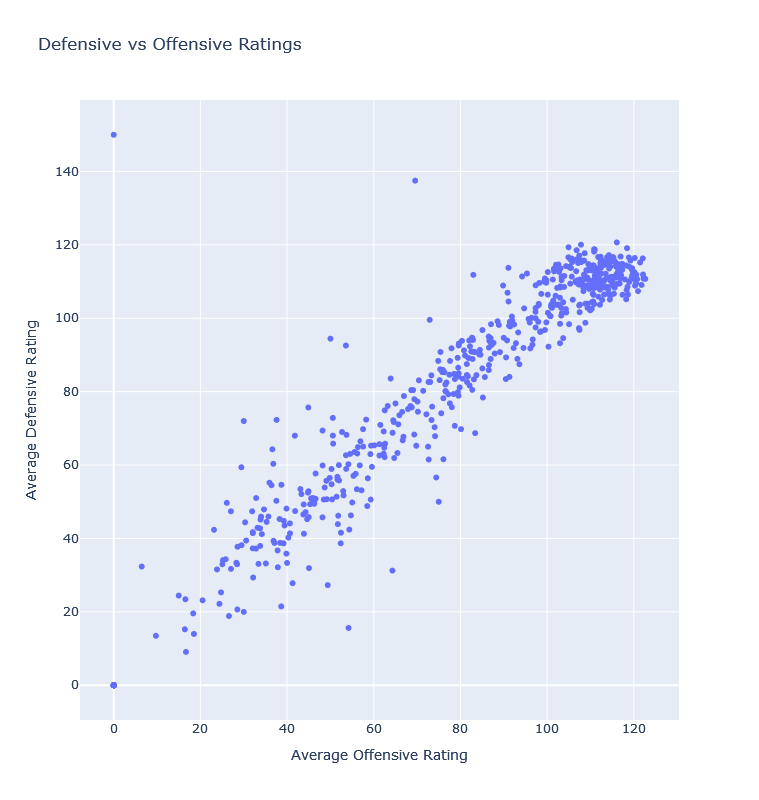

In [8]:
# Create an empty DataFrame for the results
ratings_df = pd.DataFrame(columns=['Player', 'Average_Off_Rating', 'Average_Def_Rating'])

# Calculate average ratings for each player and append to the DataFrame
for player, df in player_box.items():
    avg_off_rating = df['offensiveRating'].mean()
    avg_def_rating = df['defensiveRating'].mean()
    player_df = pd.DataFrame({
        'Player': [player],
        'Average_Off_Rating': [avg_off_rating],
        'Average_Def_Rating': [avg_def_rating]
    })
    # Append the player's DataFrame to the main DataFrame
    ratings_df = pd.concat([ratings_df, player_df], ignore_index=True)


# Create an interactive scatter plot
fig = px.scatter(
    ratings_df,
    x='Average_Off_Rating',
    y='Average_Def_Rating',
    title='Defensive vs Offensive Ratings of Each Player',
    labels={'Average_Off_Rating': 'Average Offensive Rating', 'Average_Def_Rating': 'Average Defensive Rating'}
)

# Update traces to customize hover labels GPT
fig.update_traces(
    hovertemplate='<b>%{text}</b><br>Offensive Rating: %{x}<br>Defensive Rating: %{y}<extra></extra>',
    text=ratings_df['Player'],
    mode='markers'  
)

# Ulayout 
fig.update_layout(
    xaxis_title='Average Offensive Rating',
    yaxis_title='Average Defensive Rating',
    title='Defensive vs Offensive Ratings',
    hovermode='closest',
    width=800, 
    height = 800
)

# Show the plot
fig.show()

# A little clustering

In [41]:
#remove all identifying info but personId
box23_24_slim = box23_24.drop(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug','firstName',
                                'familyName', 'nameI', 'playerSlug','comment','GAME_ID','combined_key'],axis=1)

box23_24_slim = box23_24_slim.drop(box23_24_slim.filter(like='estimated').columns, axis=1)


#convert time to seconds 
#https://stackoverflow.com/questions/63663747/pandas-convert-time-into-seconds-for-all-values-in-column
box23_24_slim['minutes']=box23_24_slim['minutes'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))

box23_24_slim.rename(columns={'minutes' : 'seconds'})

#group up players games for the season
box23_24_slim = box23_24_slim.groupby('personId').sum(numeric_only=True).reset_index()

#adding player shot location data 

#not done

shot_chart23_slim = shot_chart23.drop(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD',  'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE','GAME_DATE','HTM', 'VTM' ],axis = 1)

shot_chart23_slim = shot_chart23_slim.groupby('PLAYER_ID').sum(numeric_only=True).reset_index()

#only care about made shots for now
shot_chart23_slim = shot_chart23_slim[shot_chart23_slim['EVENT_TYPE'] == 'Made Shot']

#merge
box23_24_slim = box23_24_slim.merge(shot_chart23_slim, left_on='personId', right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))



In [126]:
shot_chart23_slim = shot_chart23.drop(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD',  'MINUTES_REMAINING',
       'SECONDS_REMAINING','GAME_DATE','HTM', 'VTM' ],axis = 1)

shot_breakdown = shot_chart23_slim.groupby(['PLAYER_ID', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).size().reset_index(name='count')

pivot_table = shot_breakdown.pivot_table(index='PLAYER_ID', 
                                         columns=['ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], 
                                         values='count', 
                                         fill_value=0)

#pivot_table.rename(columns={"PLAYER_ID', '', '', '', ''" : 'PLAYER_ID'})
#pivot_table = pivot_table.reset_index()

#flatten
pivot_table.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in pivot_table.columns]
pivot_table = pivot_table.reset_index()

box23_24_slim = box23_24_slim.merge(pivot_table_flat, left_on=pivot_table.columns[1], right_on='PLAYER_ID', how='outer',suffixes=('', '_y'))


MergeError: Not allowed to merge between different levels. (1 levels on the left, 5 on the right)

In [45]:
#scale for knn
scaled_box = StandardScaler().fit_transform(box23_24_slim)

In [46]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 5 The average silhouette_score is : 0.3079005280670132
For n_clusters = 6 The average silhouette_score is : 0.3118445752946933
For n_clusters = 7 The average silhouette_score is : 0.31092305877679016
For n_clusters = 8 The average silhouette_score is : 0.2193368677830624
For n_clusters = 9 The average silhouette_score is : 0.20468485905600606
For n_clusters = 10 The average silhouette_score is : 0.2034067582929335
For n_clusters = 11 The average silhouette_score is : 0.2031691224306024
For n_clusters = 12 The average silhouette_score is : 0.21050075570153265
For n_clusters = 13 The average silhouette_score is : 0.2121795472470042
For n_clusters = 14 The average silhouette_score is : 0.21470190125177183
For n_clusters = 15 The average silhouette_score is : 0.2144809949030066
For n_clusters = 16 The average silhouette_score is : 0.2305814015867702
For n_clusters = 17 The average silhouette_score is : 0.22710981925355567
For n_clusters = 18 The average silhouette_score is

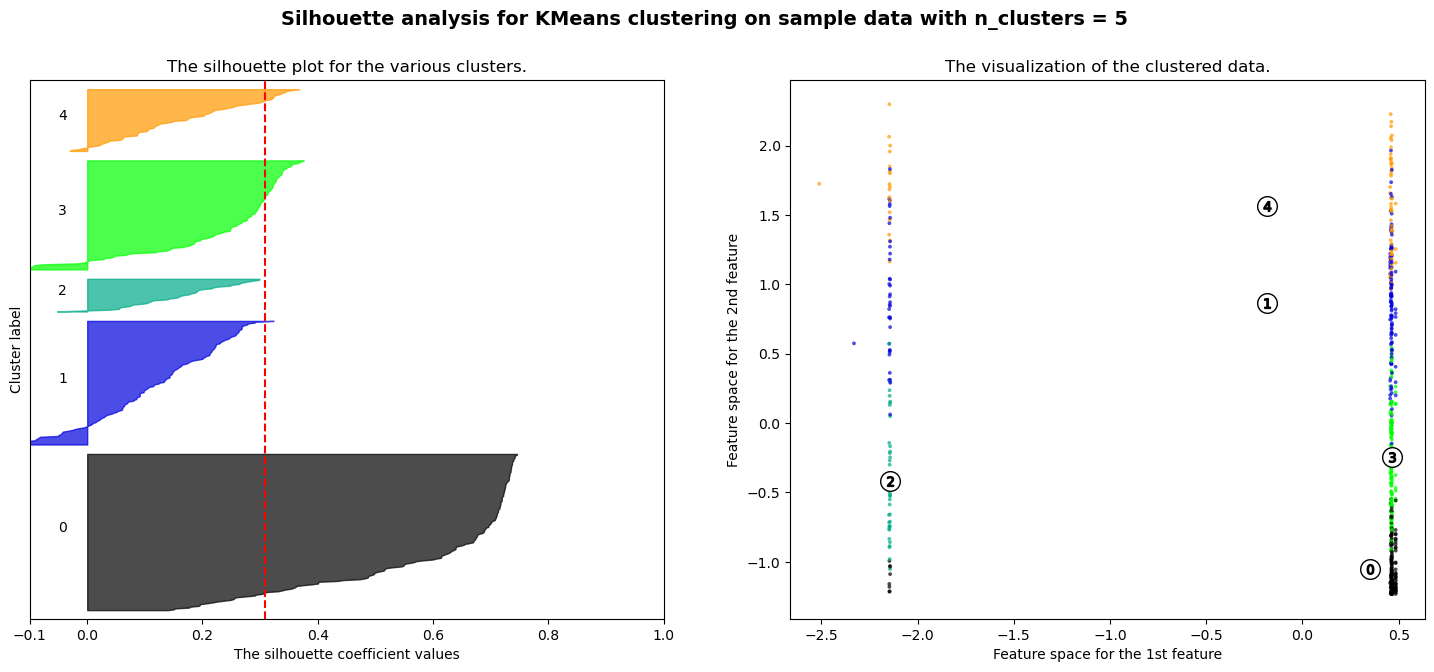

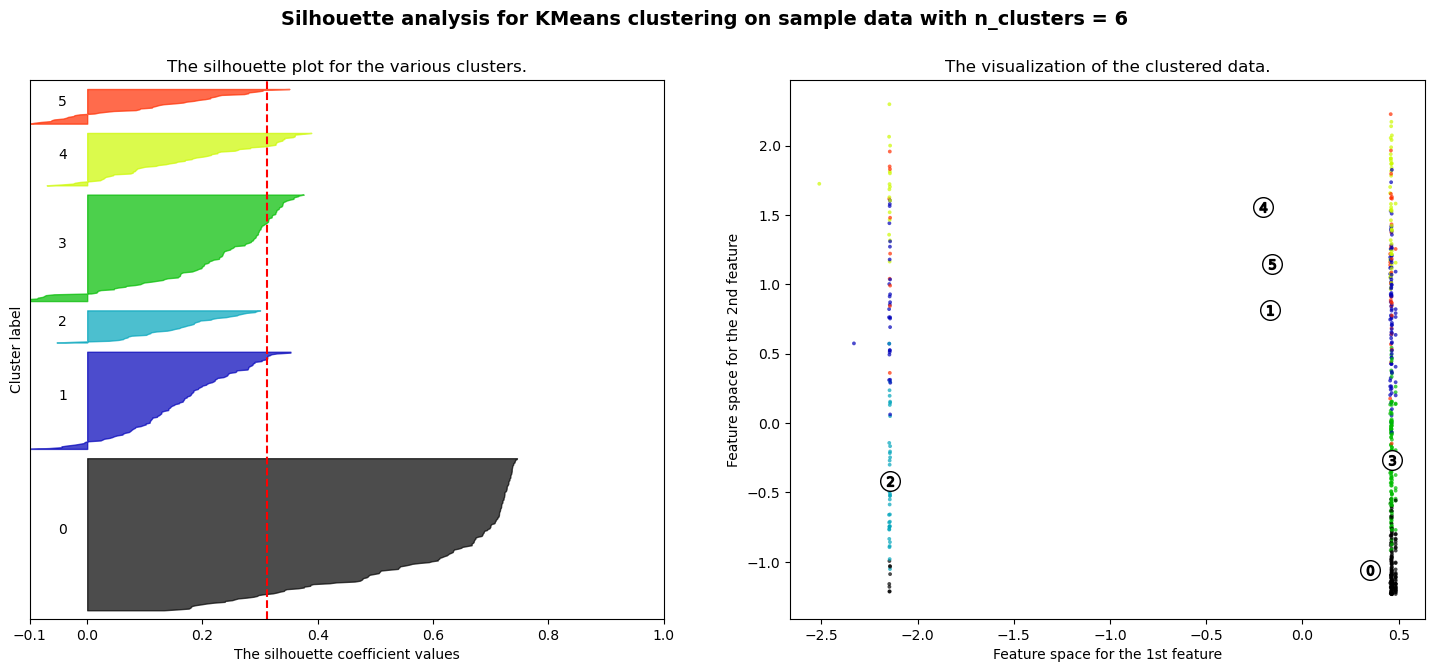

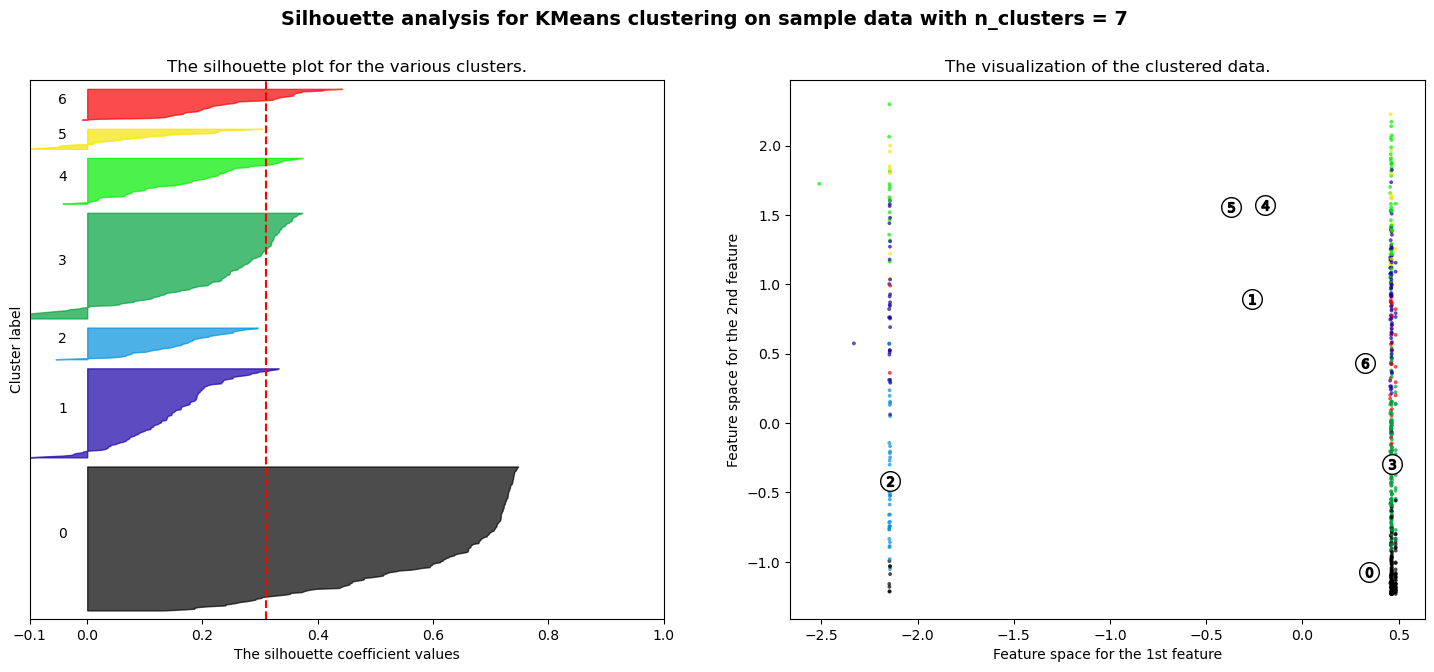

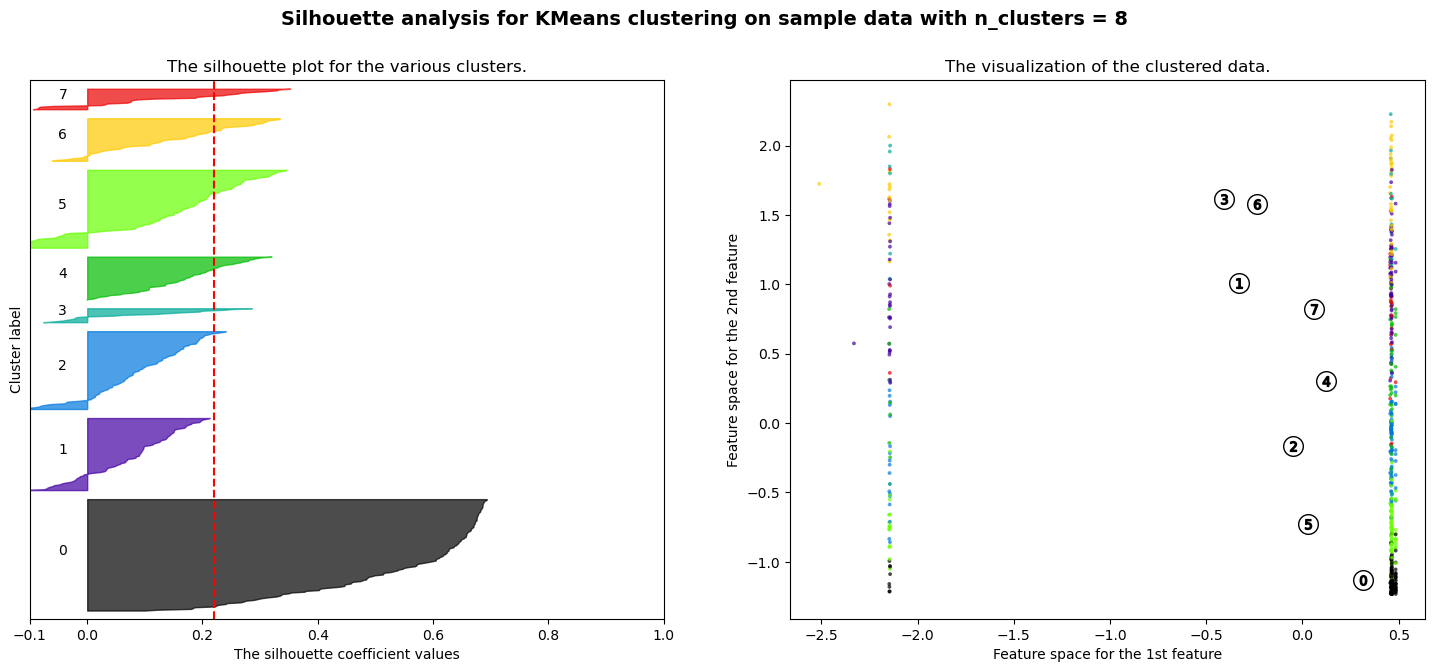

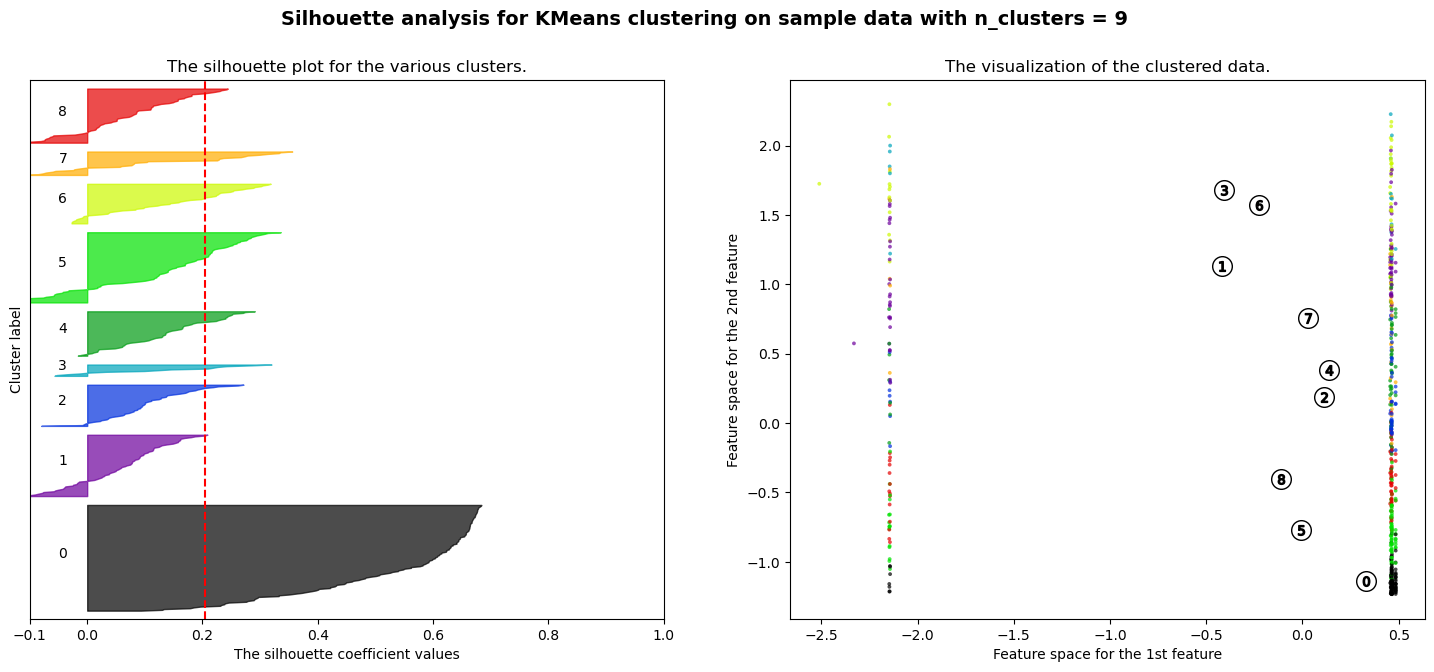

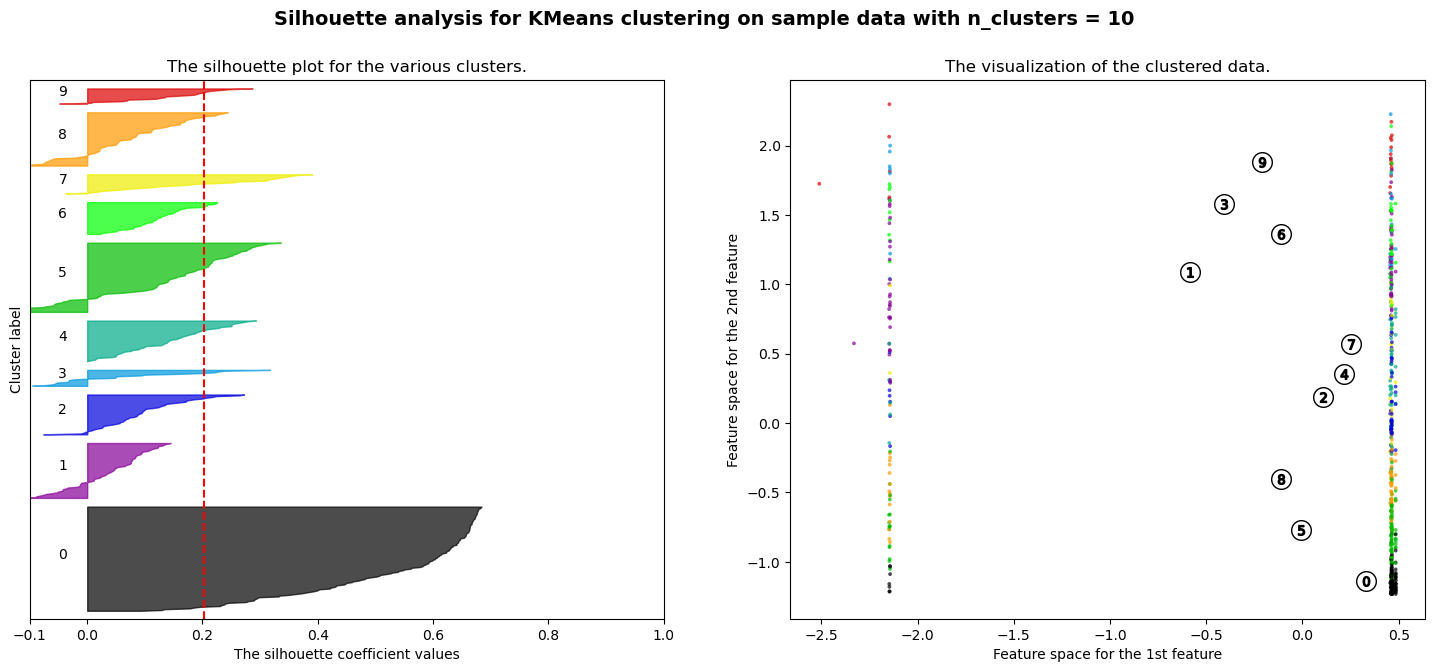

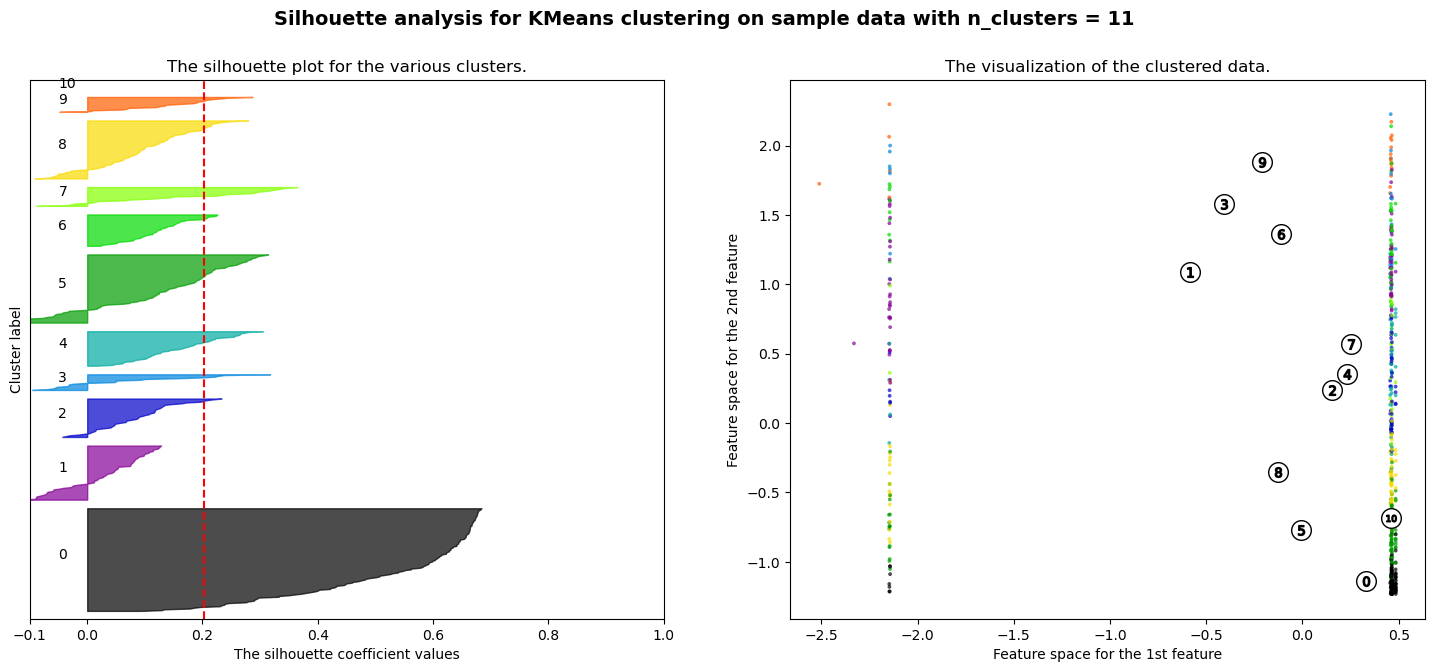

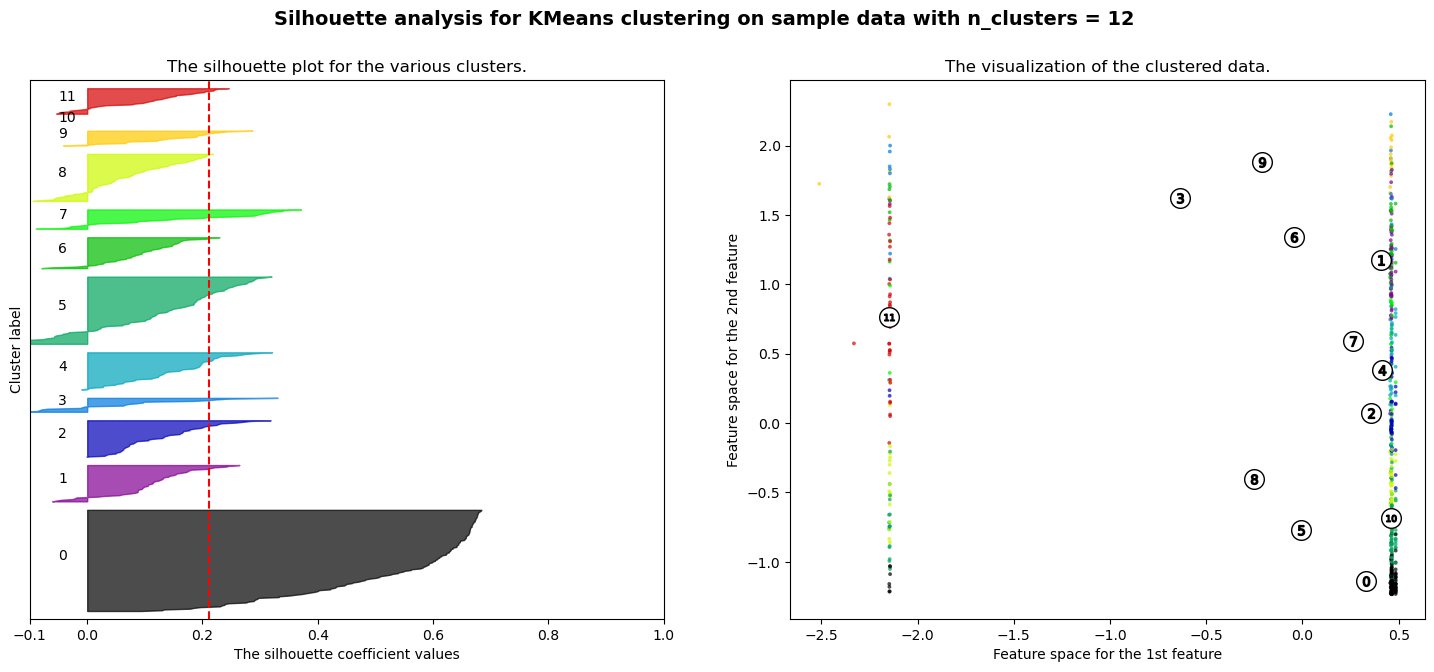

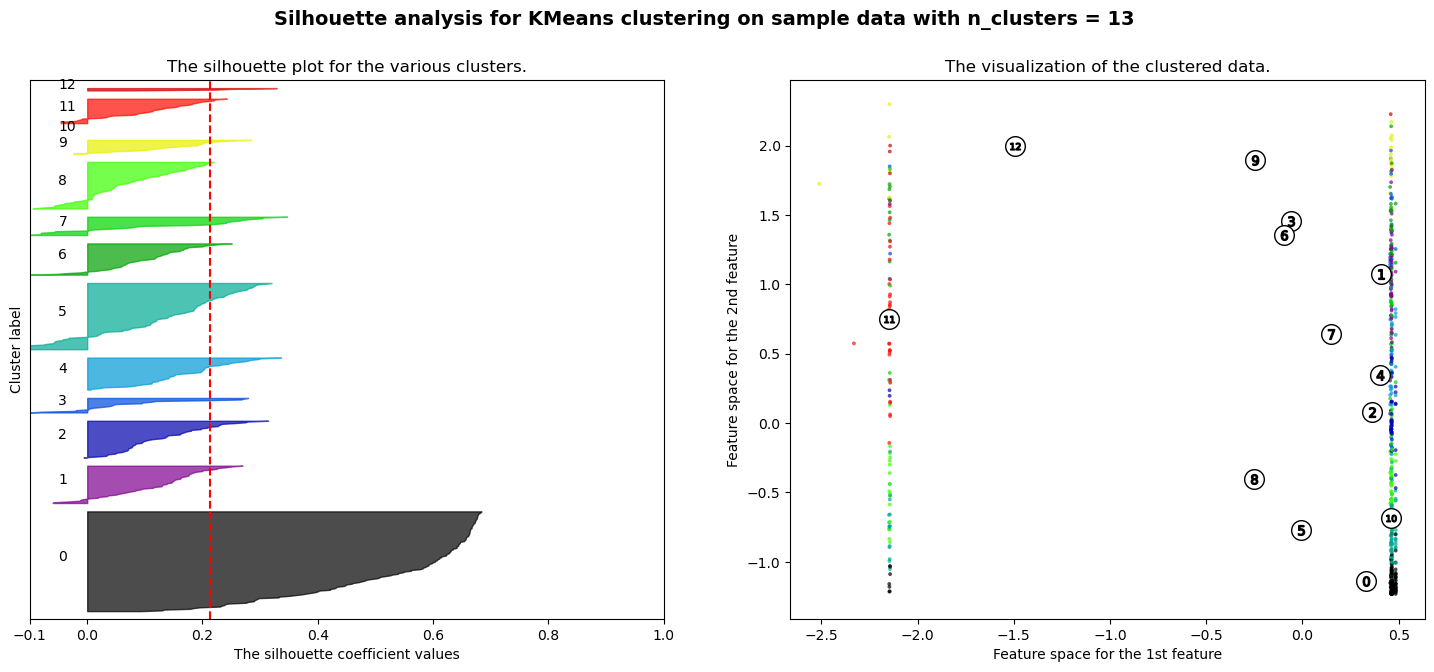

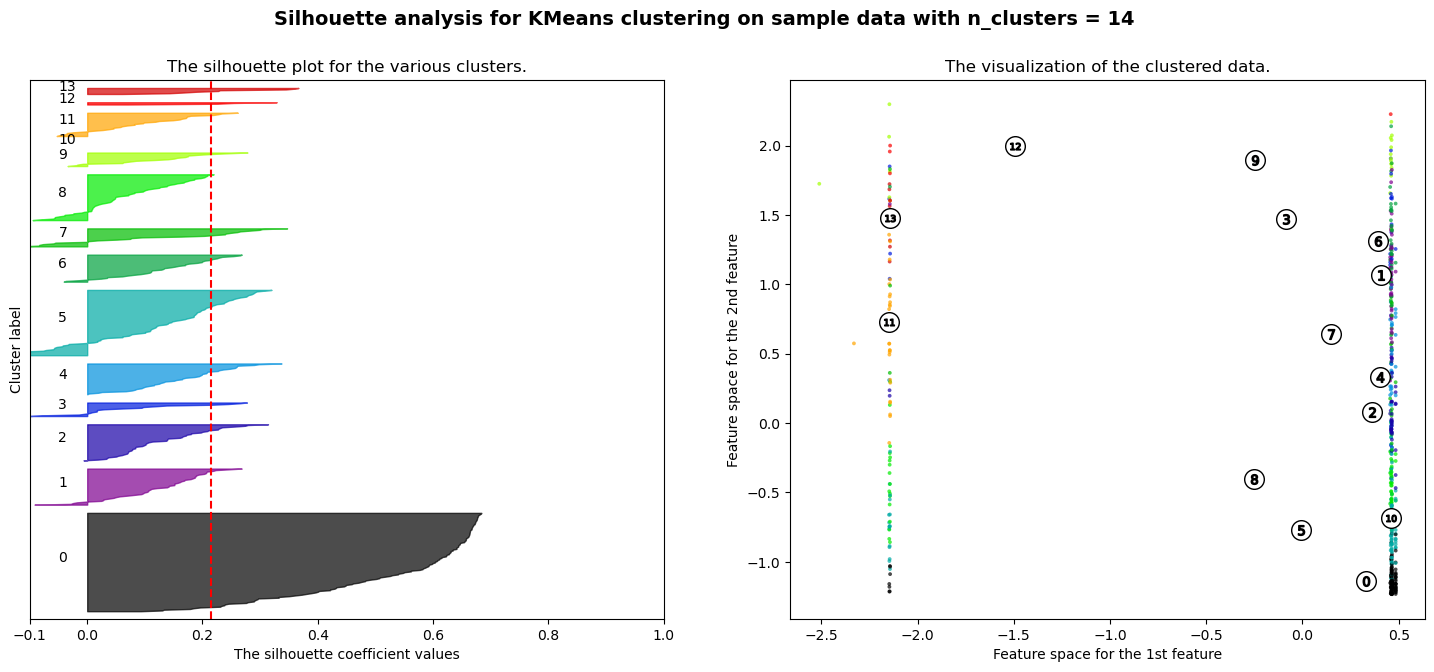

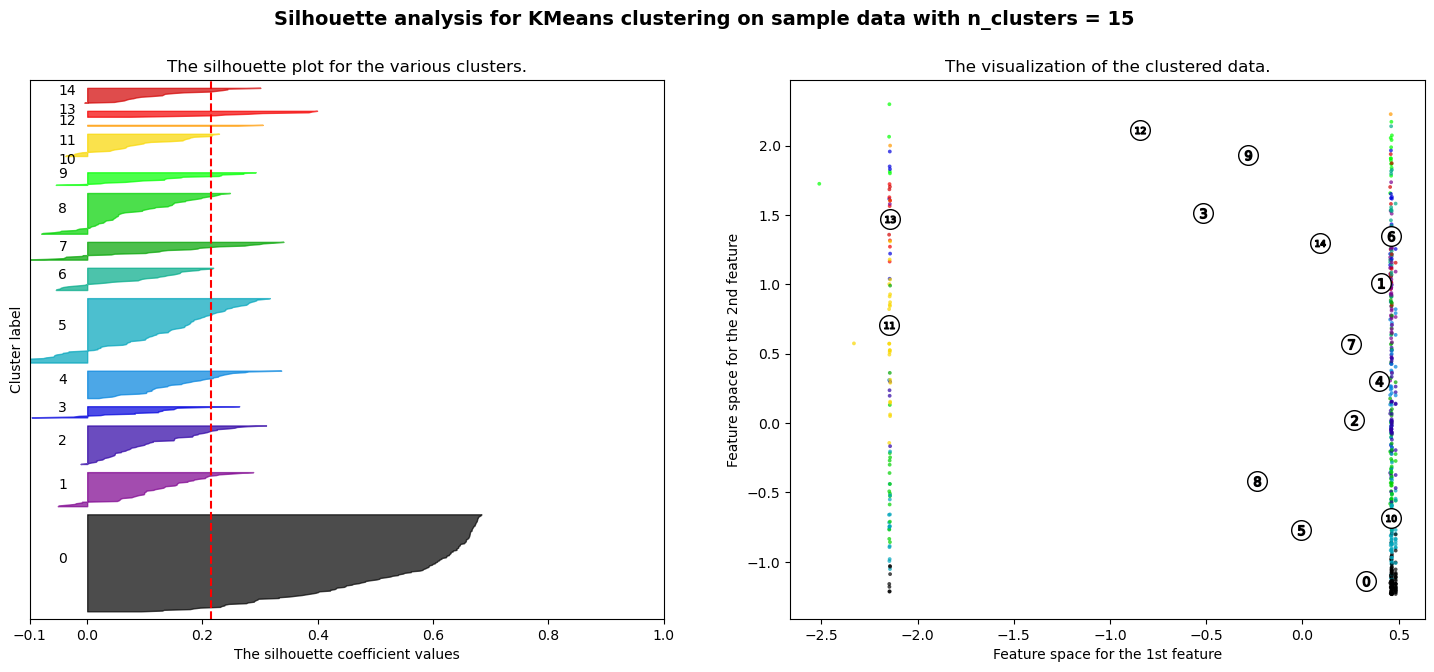

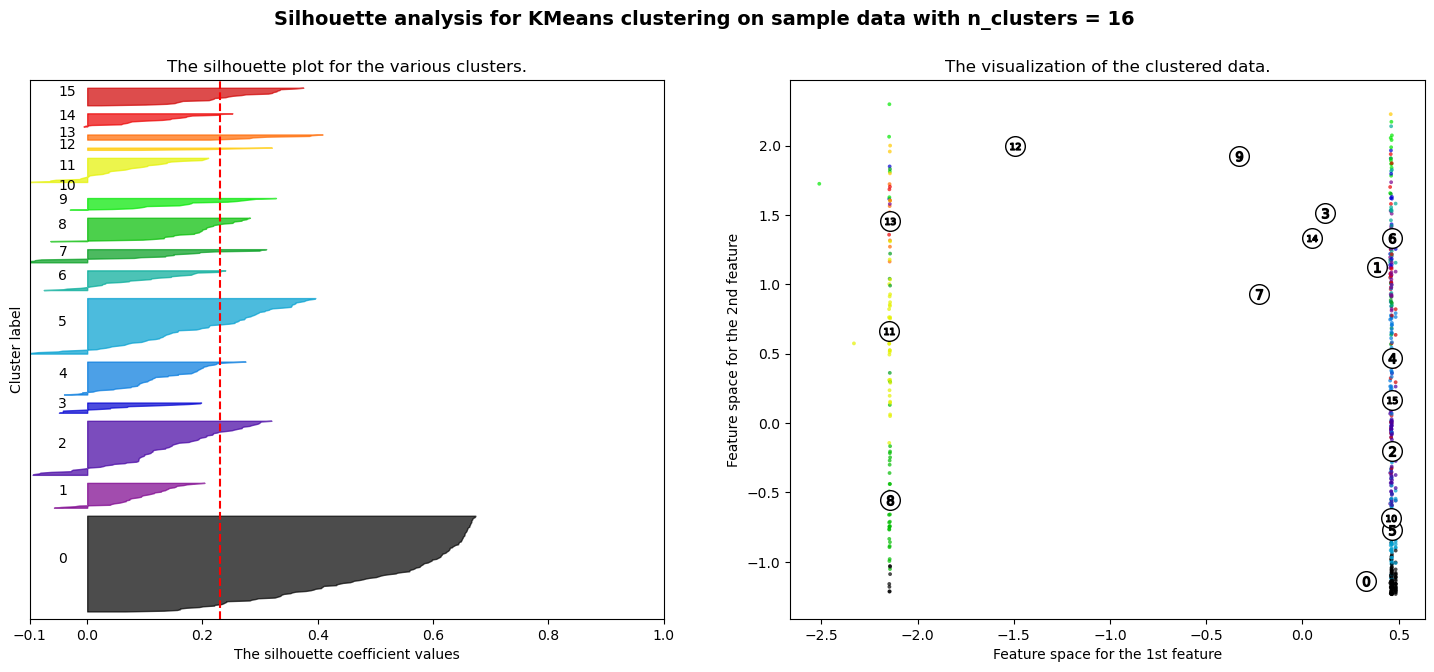

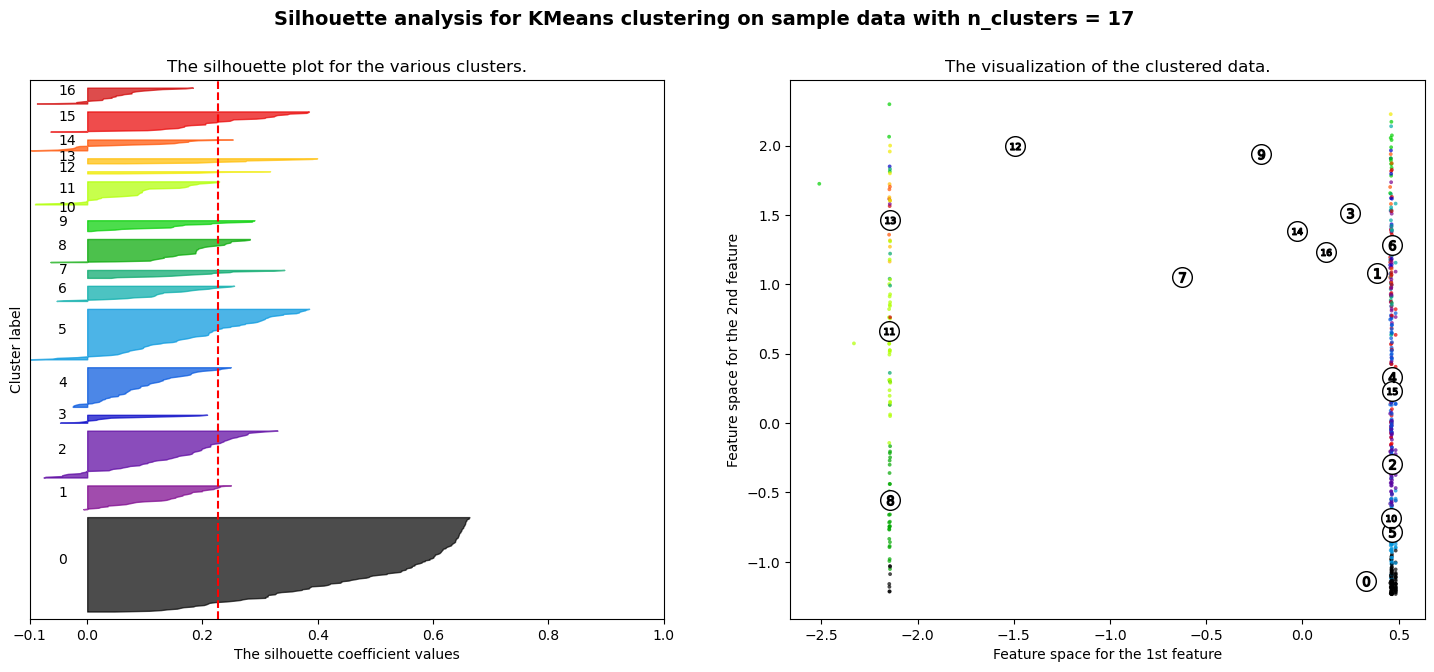

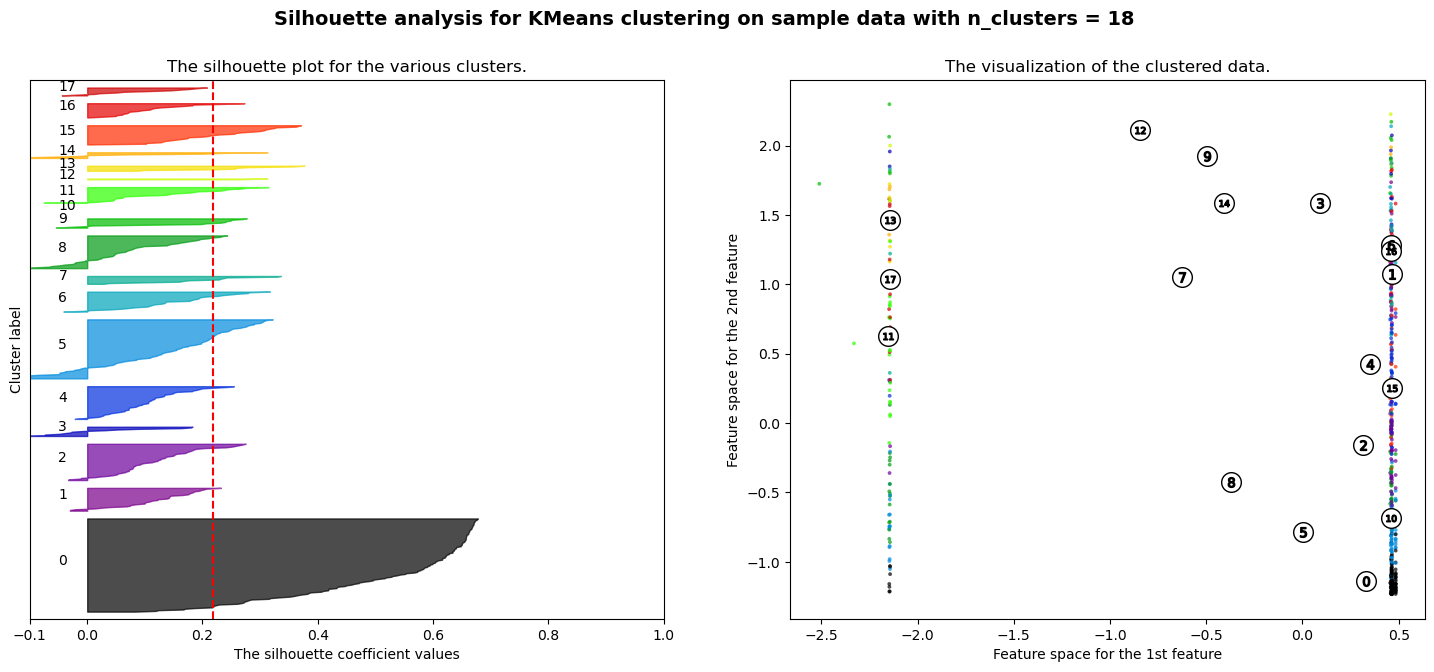

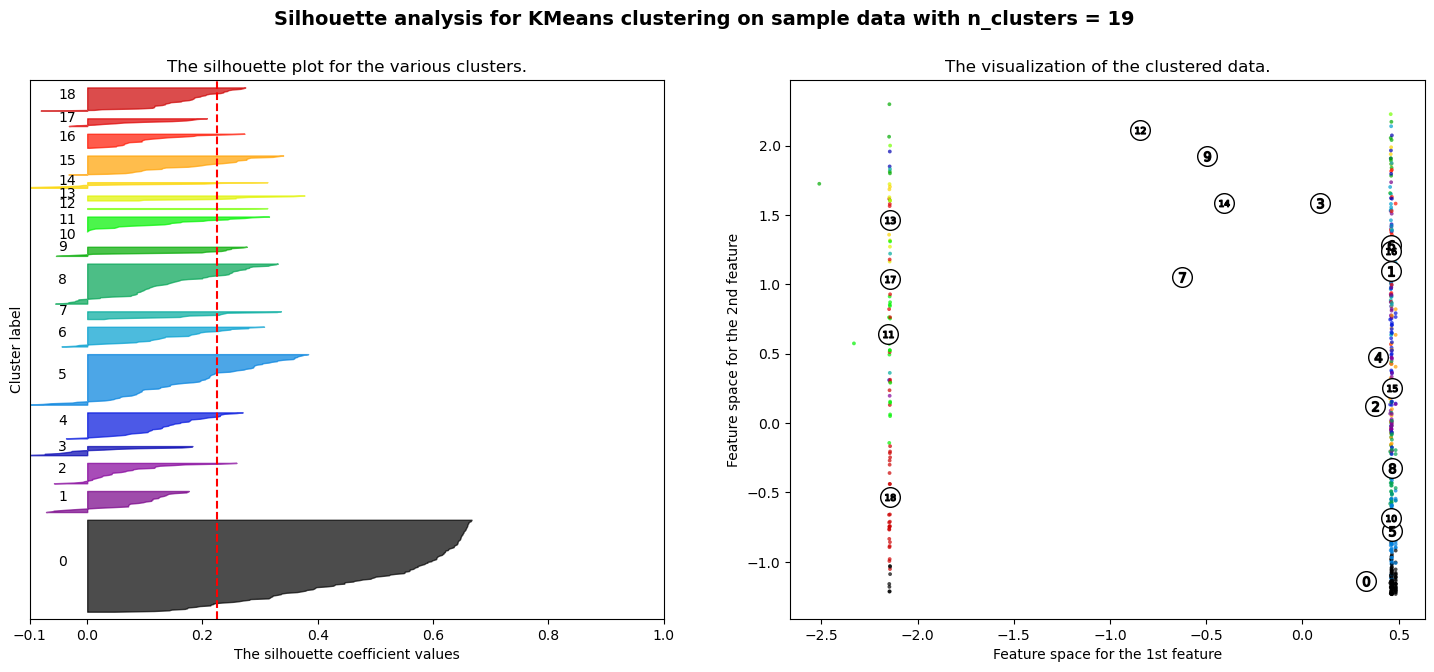

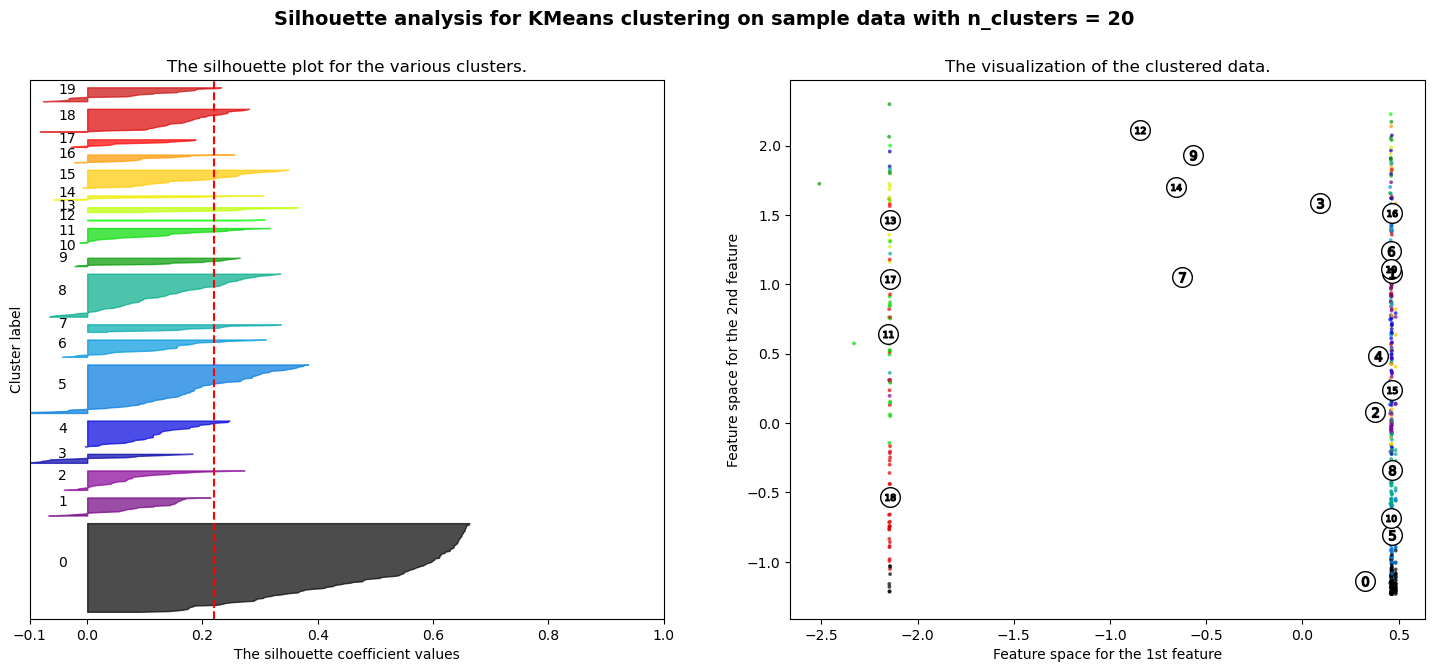

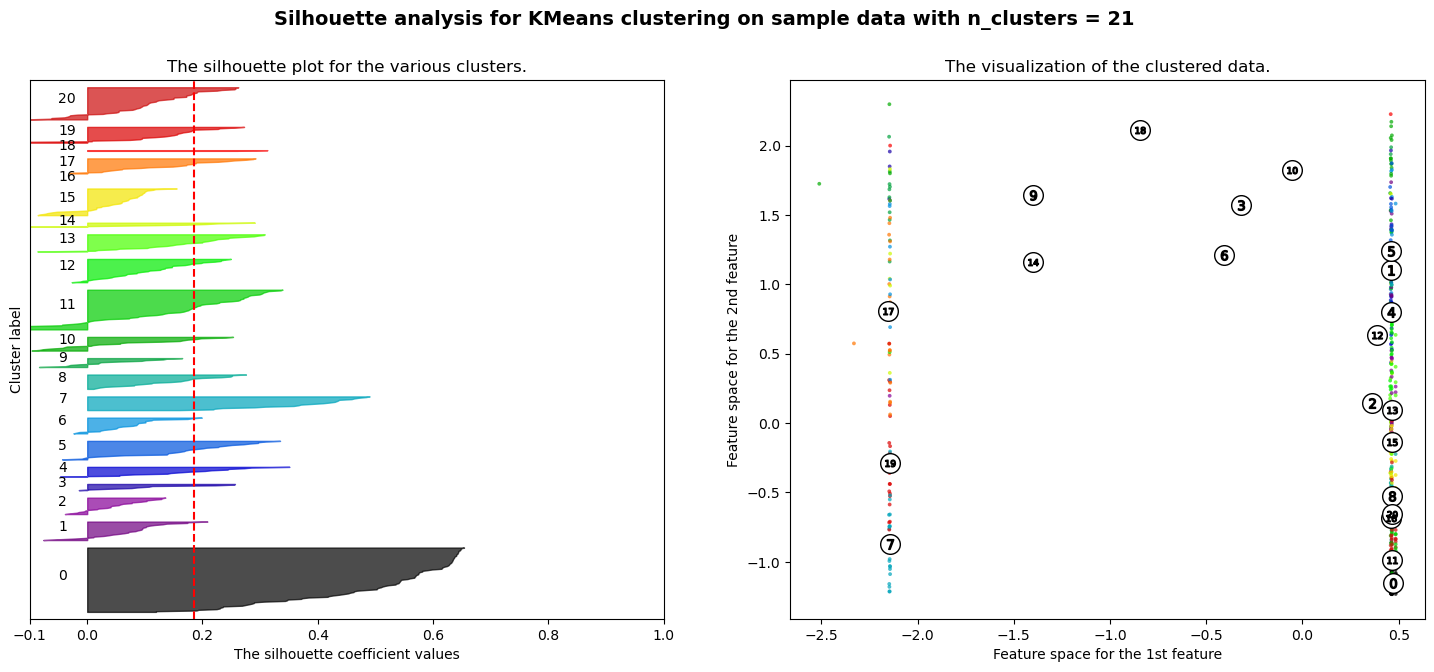

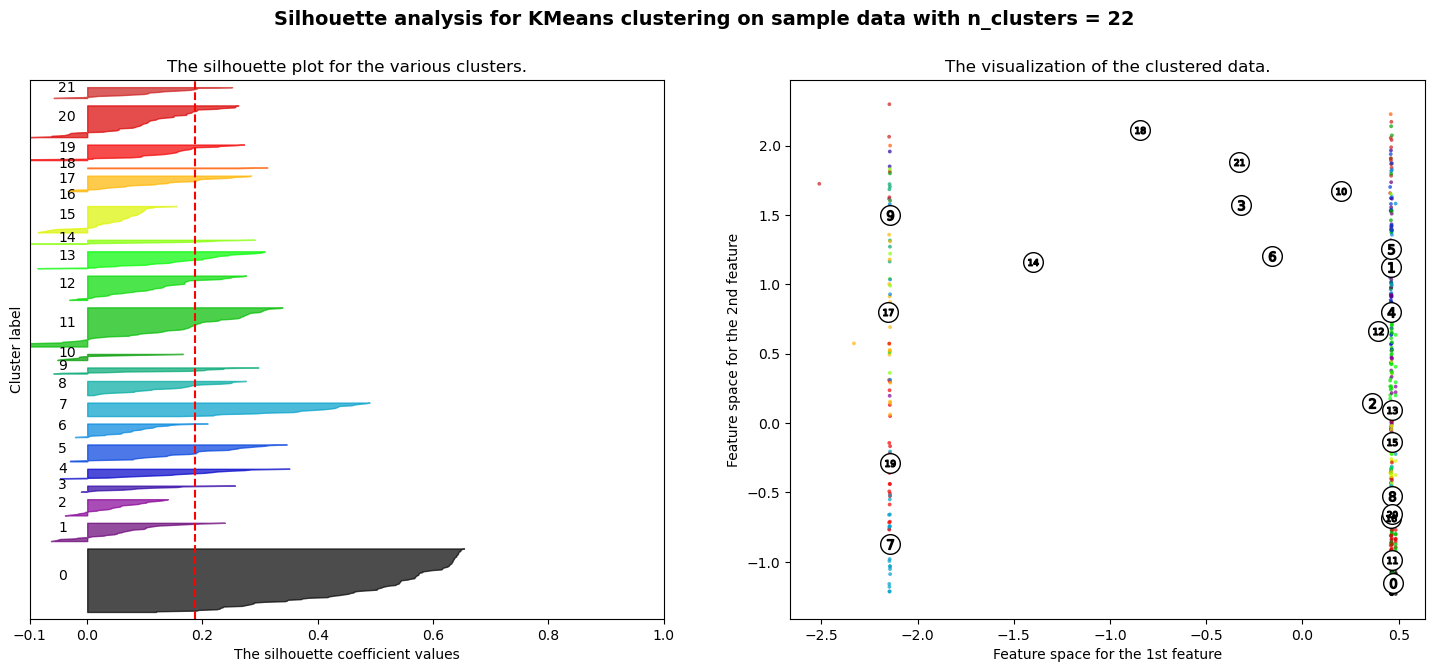

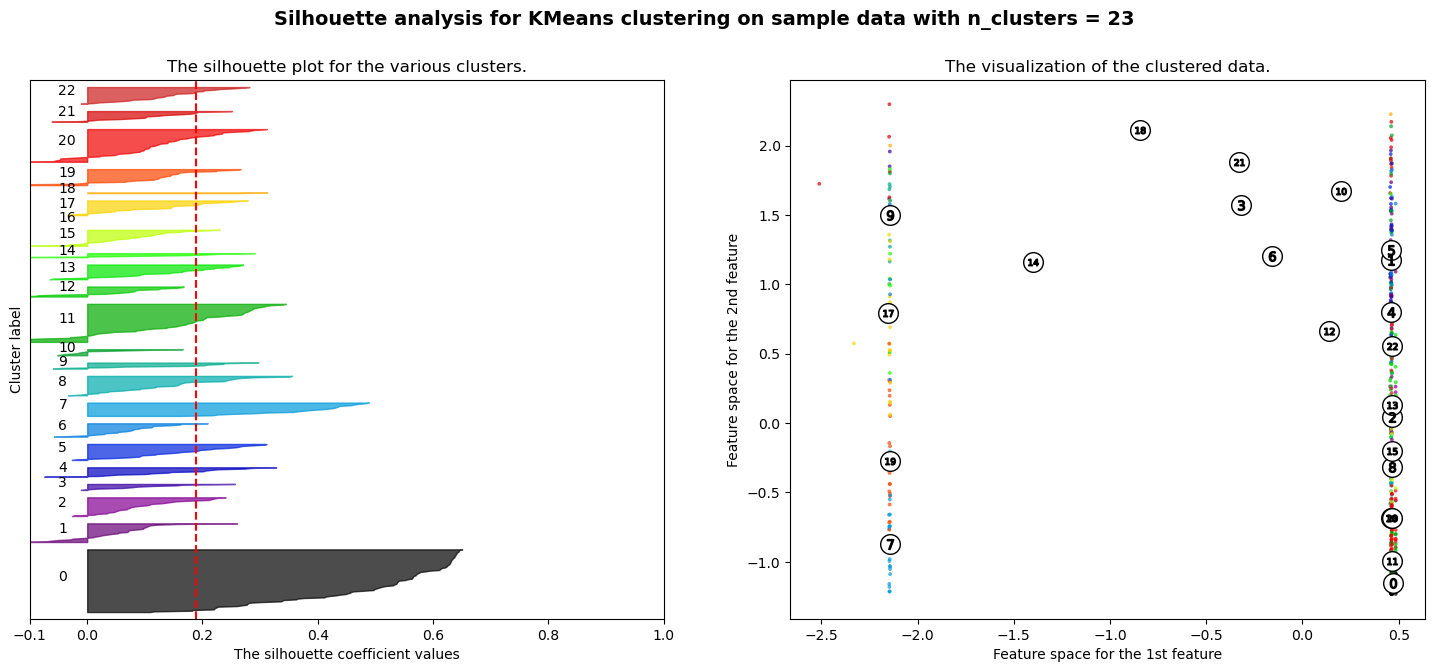

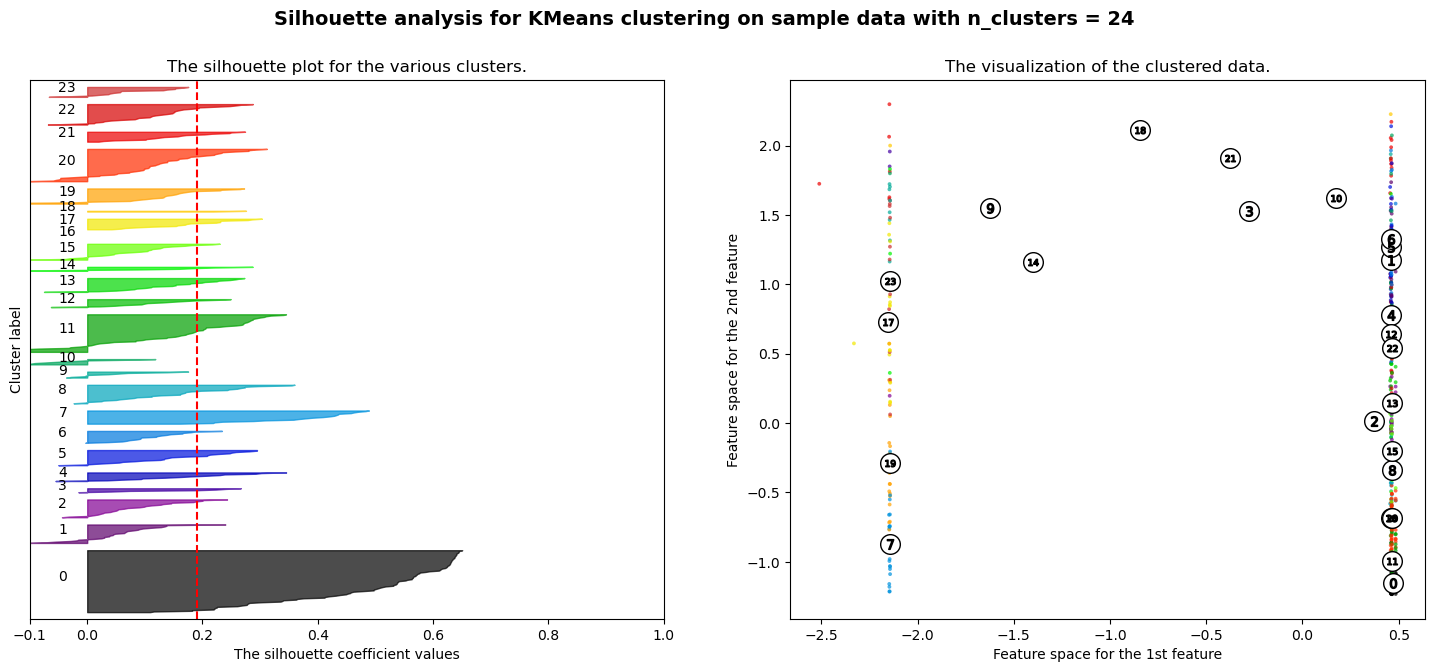

In [48]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
range_n_clusters = range(5,25)
X = scaled_box


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10,  n_init='auto', max_iter=300,)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()